Performance testing with the generation of graphics to show diferences

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from graph.car import Car
import graph.graph_parser as gp
from graph.node import Node
from algorithms.bfs import BFS
from algorithms.dfs import DFS
from algorithms.a_star import A_STAR
from algorithms.greedy import GREEDY
from algorithms.iterative_dfs import ITERATIVE_DFS
from statistics import mean
import pandas as pd
import pygame
import signal
import os
import random
import time
import sys

pygame 2.1.2 (SDL 2.0.16, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


Set Static Variables

In [2]:
sys.setrecursionlimit(10**4)
NumberOfCars=3
StatisticsToShow=['TimeCost','Distance','TopSpeed','AvgSpeed','MedSpeed','StdSpeed','VarSpeed','P25Speed','P50Speed','P75Speed']#TimeCost,Distance,TopSpeed,AvgSpeed,MedSpeed,StdSpeed,VarSpeed,P25Speed,P50Speed,P75Speed




StatMethod={
    "Distance":"cost",
    "TopSpeed":"getTopSpeed",
    "AvgSpeed":"getAverageSpeed",
    "MedSpeed":"getMedian",
    "StdSpeed":"getStd",
    "VarSpeed":"getVar",
    "P25Speed":"get25Percentil",
    "P50Speed":"get50Percentil",
    "P75Speed":"get75Percentil",
}

Find all circuits that exist
circuits will have the format (Name,File path)

In [3]:
circuits=[]

with os.scandir('gui/circuits/') as circuitsFiles:
    for circuit in circuitsFiles:
        name=circuit.name
        trackName=name.split('.')[0]
        circuits.append((trackName,f'gui/circuits/{name}'))


Get all the algoriths that will be used
algorithms will have the format (Name,class object)

In [4]:
algorithms=[
    ("Depth First Search",DFS()),
    ("Breath First Search",BFS()),
    ("A*",A_STAR()),
    ("Greedy",GREEDY()),
    ("DFS-it",ITERATIVE_DFS())
    ]

Helper Functions to make the simulation and creating the graph from the sircuit file

In [5]:
def getMatrix(inputImage):
        """
           creates surfaces for the track components and defines max timeline position
        """
        image =  pygame.image.load(inputImage)
        resized_image=pygame.transform.scale(image,(100,50))
        greens=pygame.mask.from_threshold(resized_image,(0,255,0),threshold=(30, 50, 30, 255))
        reds=pygame.mask.from_threshold(resized_image,(255,0,0),threshold=(50, 30, 30, 255))
        blacks=pygame.mask.from_threshold(resized_image,(0,0,0),threshold=(100, 100, 100, 255))
    
        matrix=[]
        for r in range(50):
            f=''
            for c in range(100):
                if greens.get_at((c,r)):
                    f+='P'
                elif reds.get_at((c,r)):
                    f+='F'
                elif blacks.get_at((c,r)):
                    f+='-'
                else:
                    f+='X'
            matrix.append(f)
        return matrix



def getGraphFromImage(inputImage):
    matrix = getMatrix(inputImage)
    graph=gp.circuit_from_matrix(matrix)
    return graph

def timeout(signum, frame):
    raise Exception("end of time")

signal.signal(signal.SIGALRM, timeout)

def simulate(algorithm,graph):
    """
       Uses the algorithm in the track to simulate the car
    """
    timedCars=[]
    cars=[]
    startingNodes=random.choices(graph.starts,k=NumberOfCars)
    for i in range(NumberOfCars):
        cars.append(Car(Node(startingNodes[i][0],startingNodes[i][1],0,0)))
        start=time.time()
        try:
            signal.alarm(45)
            algorithm.search(graph,i,cars, graph.finishes)
            signal.alarm(0)
            d=True
        except Exception:
            d=False
        if d:
            timedCars.append((time.time()-start,cars[i]))
    return timedCars







In [6]:
data={}

for circuitN,circuitF in circuits:
    graph=getGraphFromImage(circuitF)
    for algorithmN,algorithmI in algorithms:
        print(circuitN,algorithmN)
        cars=simulate(algorithmI,graph)
        if cars==[]:
            for statA in StatisticsToShow:
                if statA not in data:
                    data[statA]={}
                if circuitN not in data[statA]:
                    data[statA][circuitN] = []
                data[statA][circuitN].append(0)
            continue
            
        costcar=list(zip(*cars)) # transpose
        cost=costcar[0]
        car = costcar[1]
        
        for statA in StatisticsToShow:
            if statA not in data:
                data[statA]={}
            if circuitN not in data[statA]:
                data[statA][circuitN] = []
            if statA=='TimeCost':
                data[statA][circuitN].append(np.mean(cost))
                continue
            funcs = list(map(lambda x:getattr(x,StatMethod[statA]),car))
            if statA=='Distance':
                data[statA][circuitN].append(np.mean(funcs))
                continue
            values = list(map(lambda x: x(),funcs))
            data[statA][circuitN].append(np.mean(values))

drag Depth First Search
drag Breath First Search
drag A*
drag Greedy
drag DFS-it
spielberg Depth First Search
spielberg Breath First Search
spielberg A*
spielberg Greedy
spielberg DFS-it
overkill Depth First Search
overkill Breath First Search
overkill A*


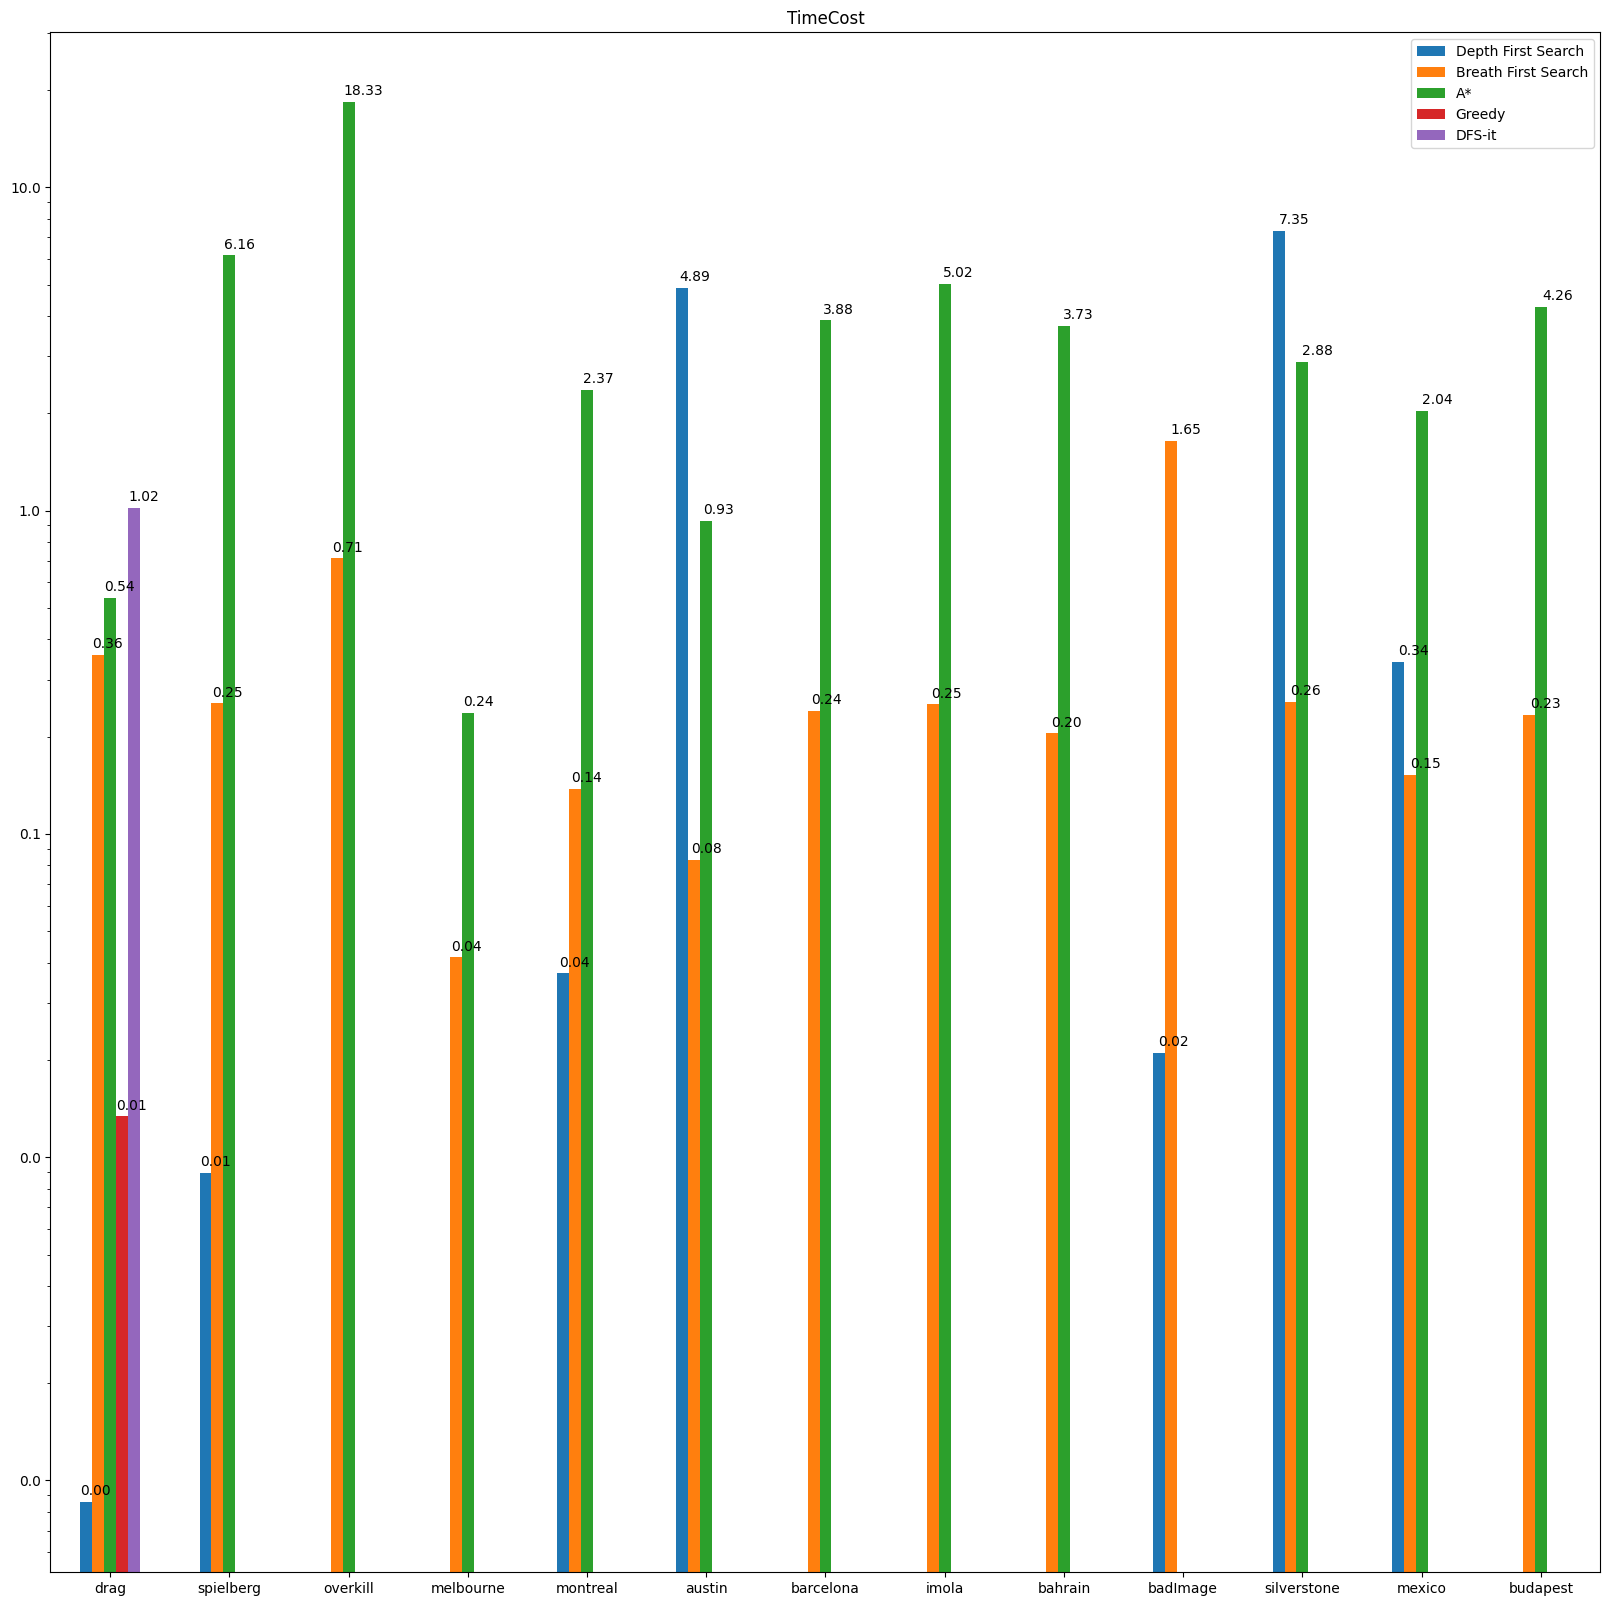

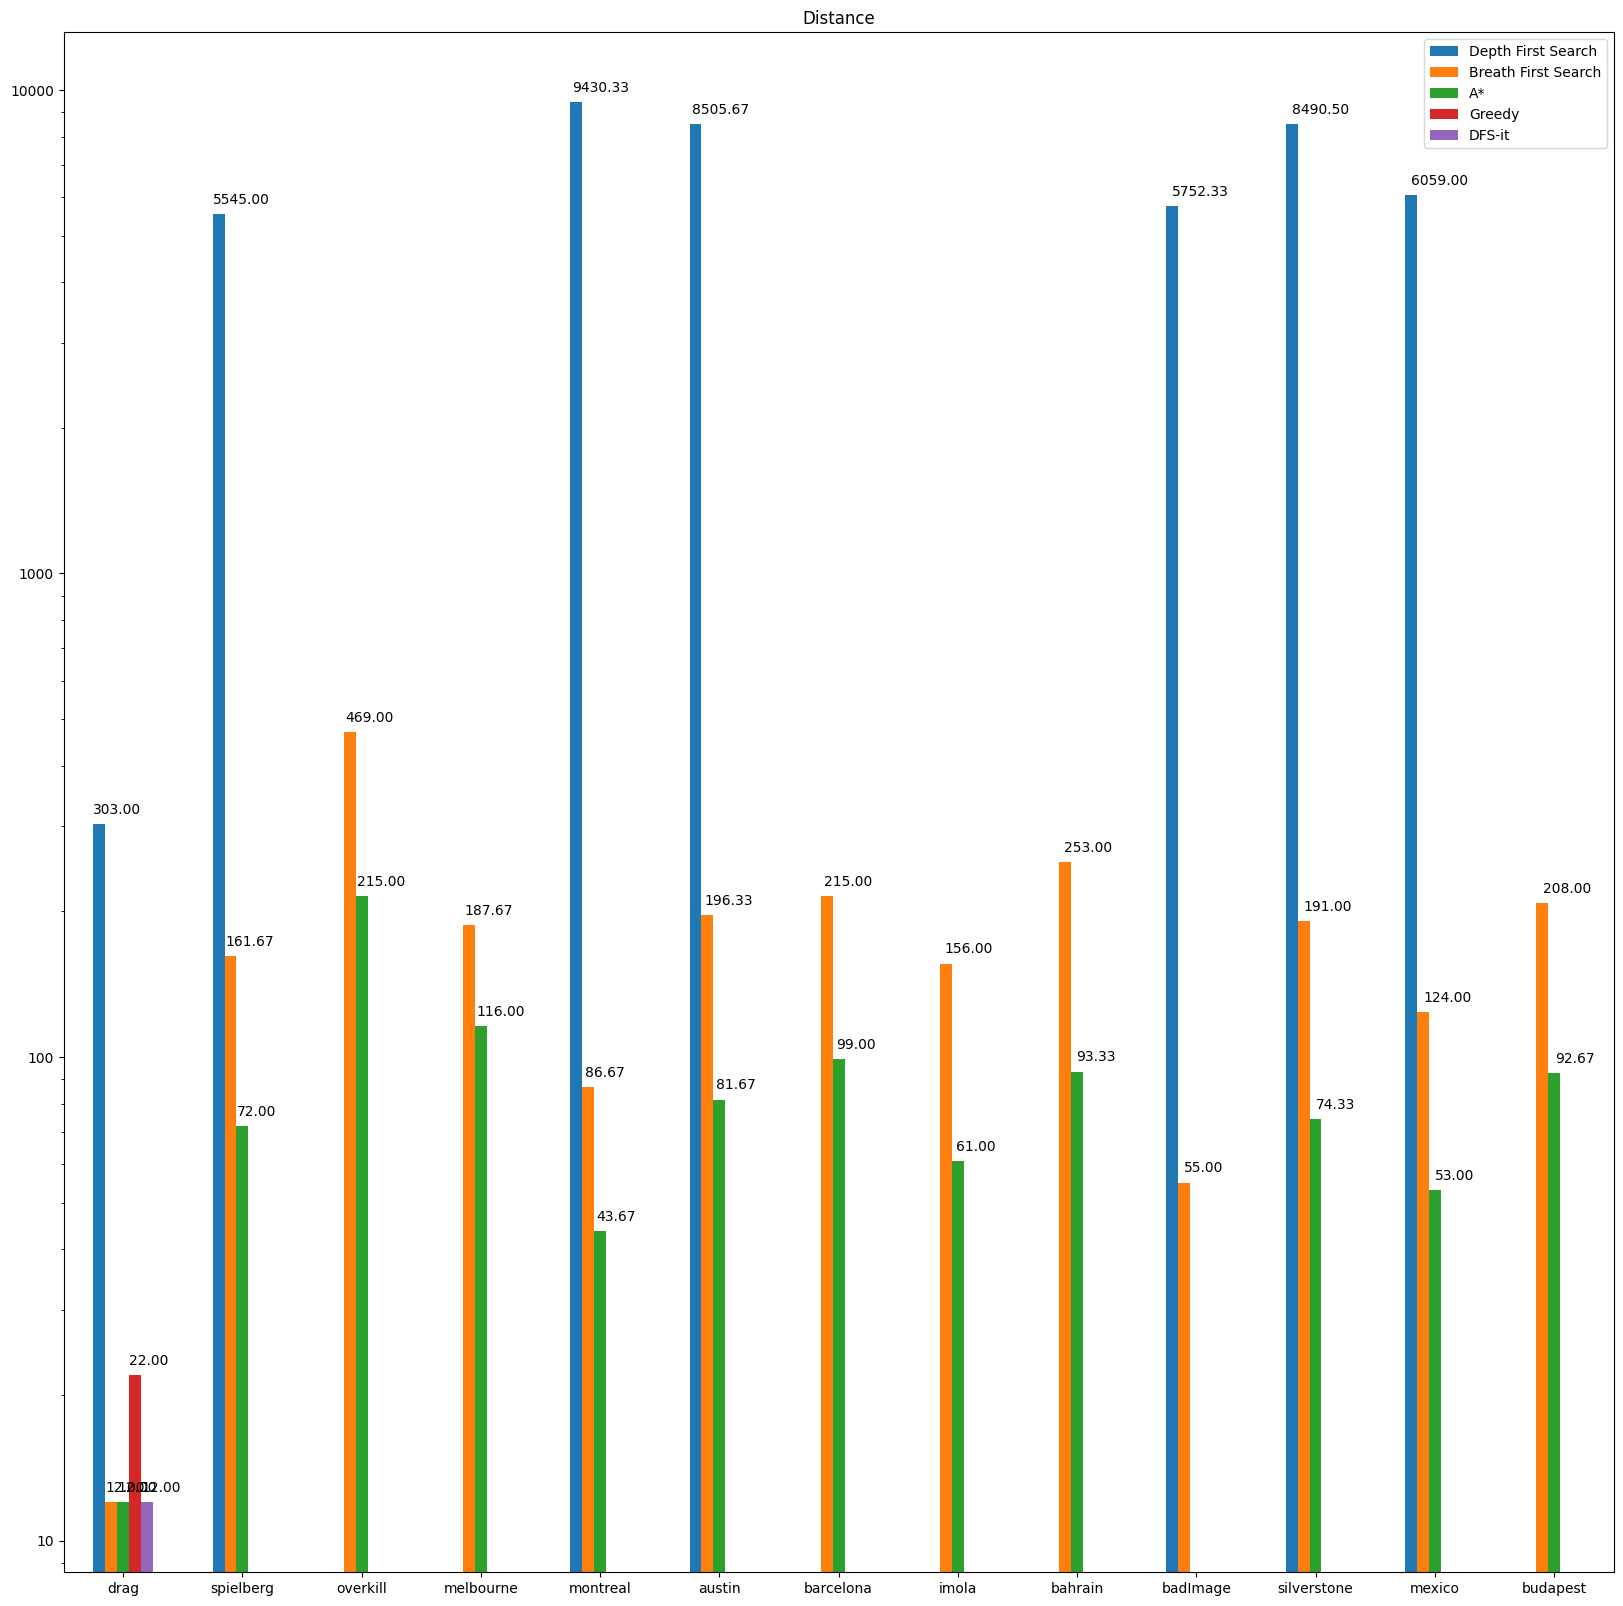

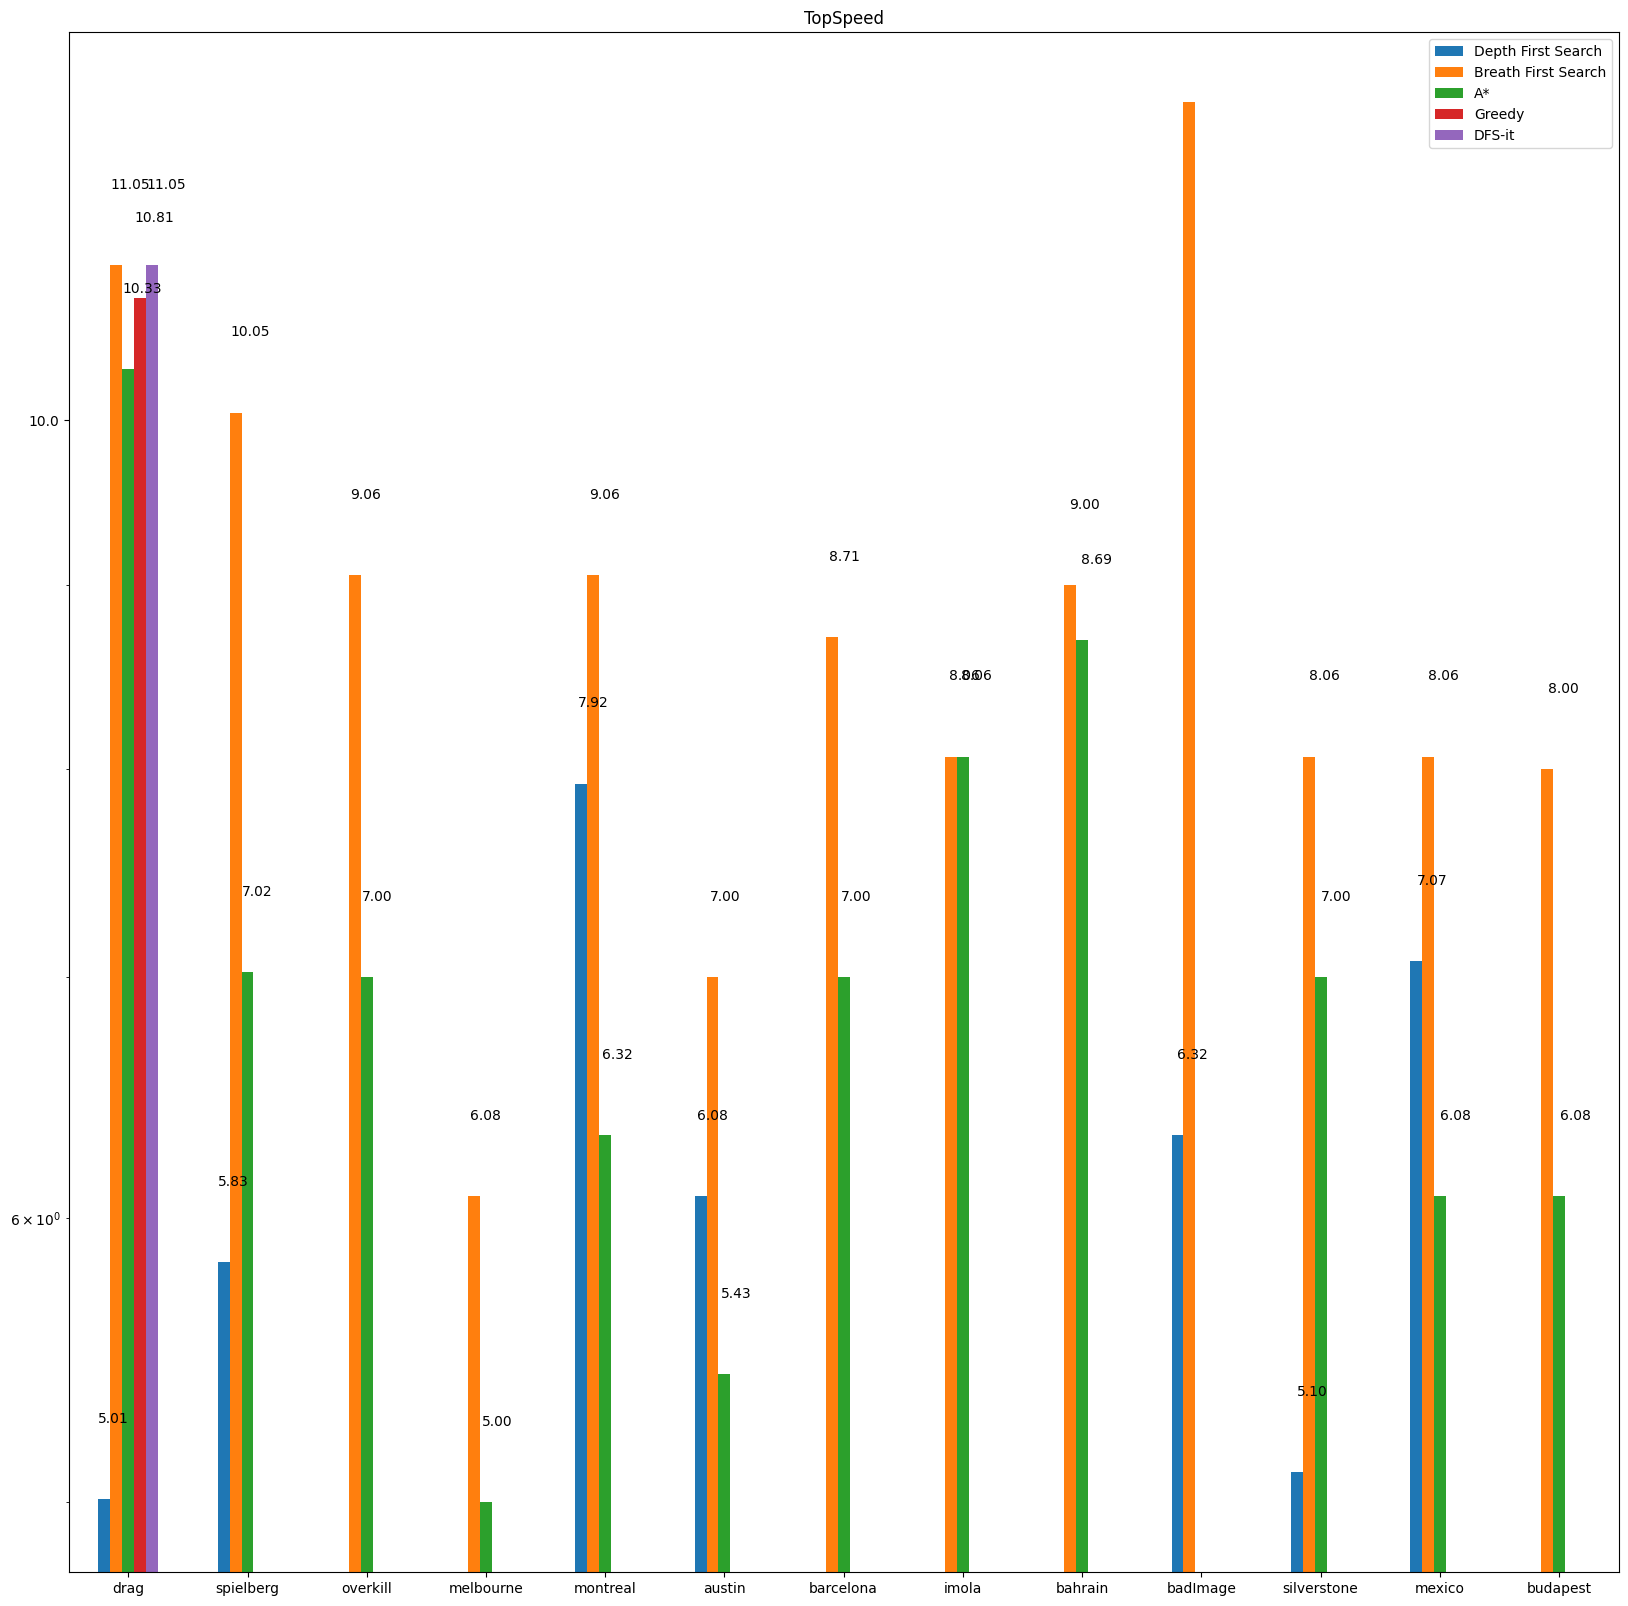

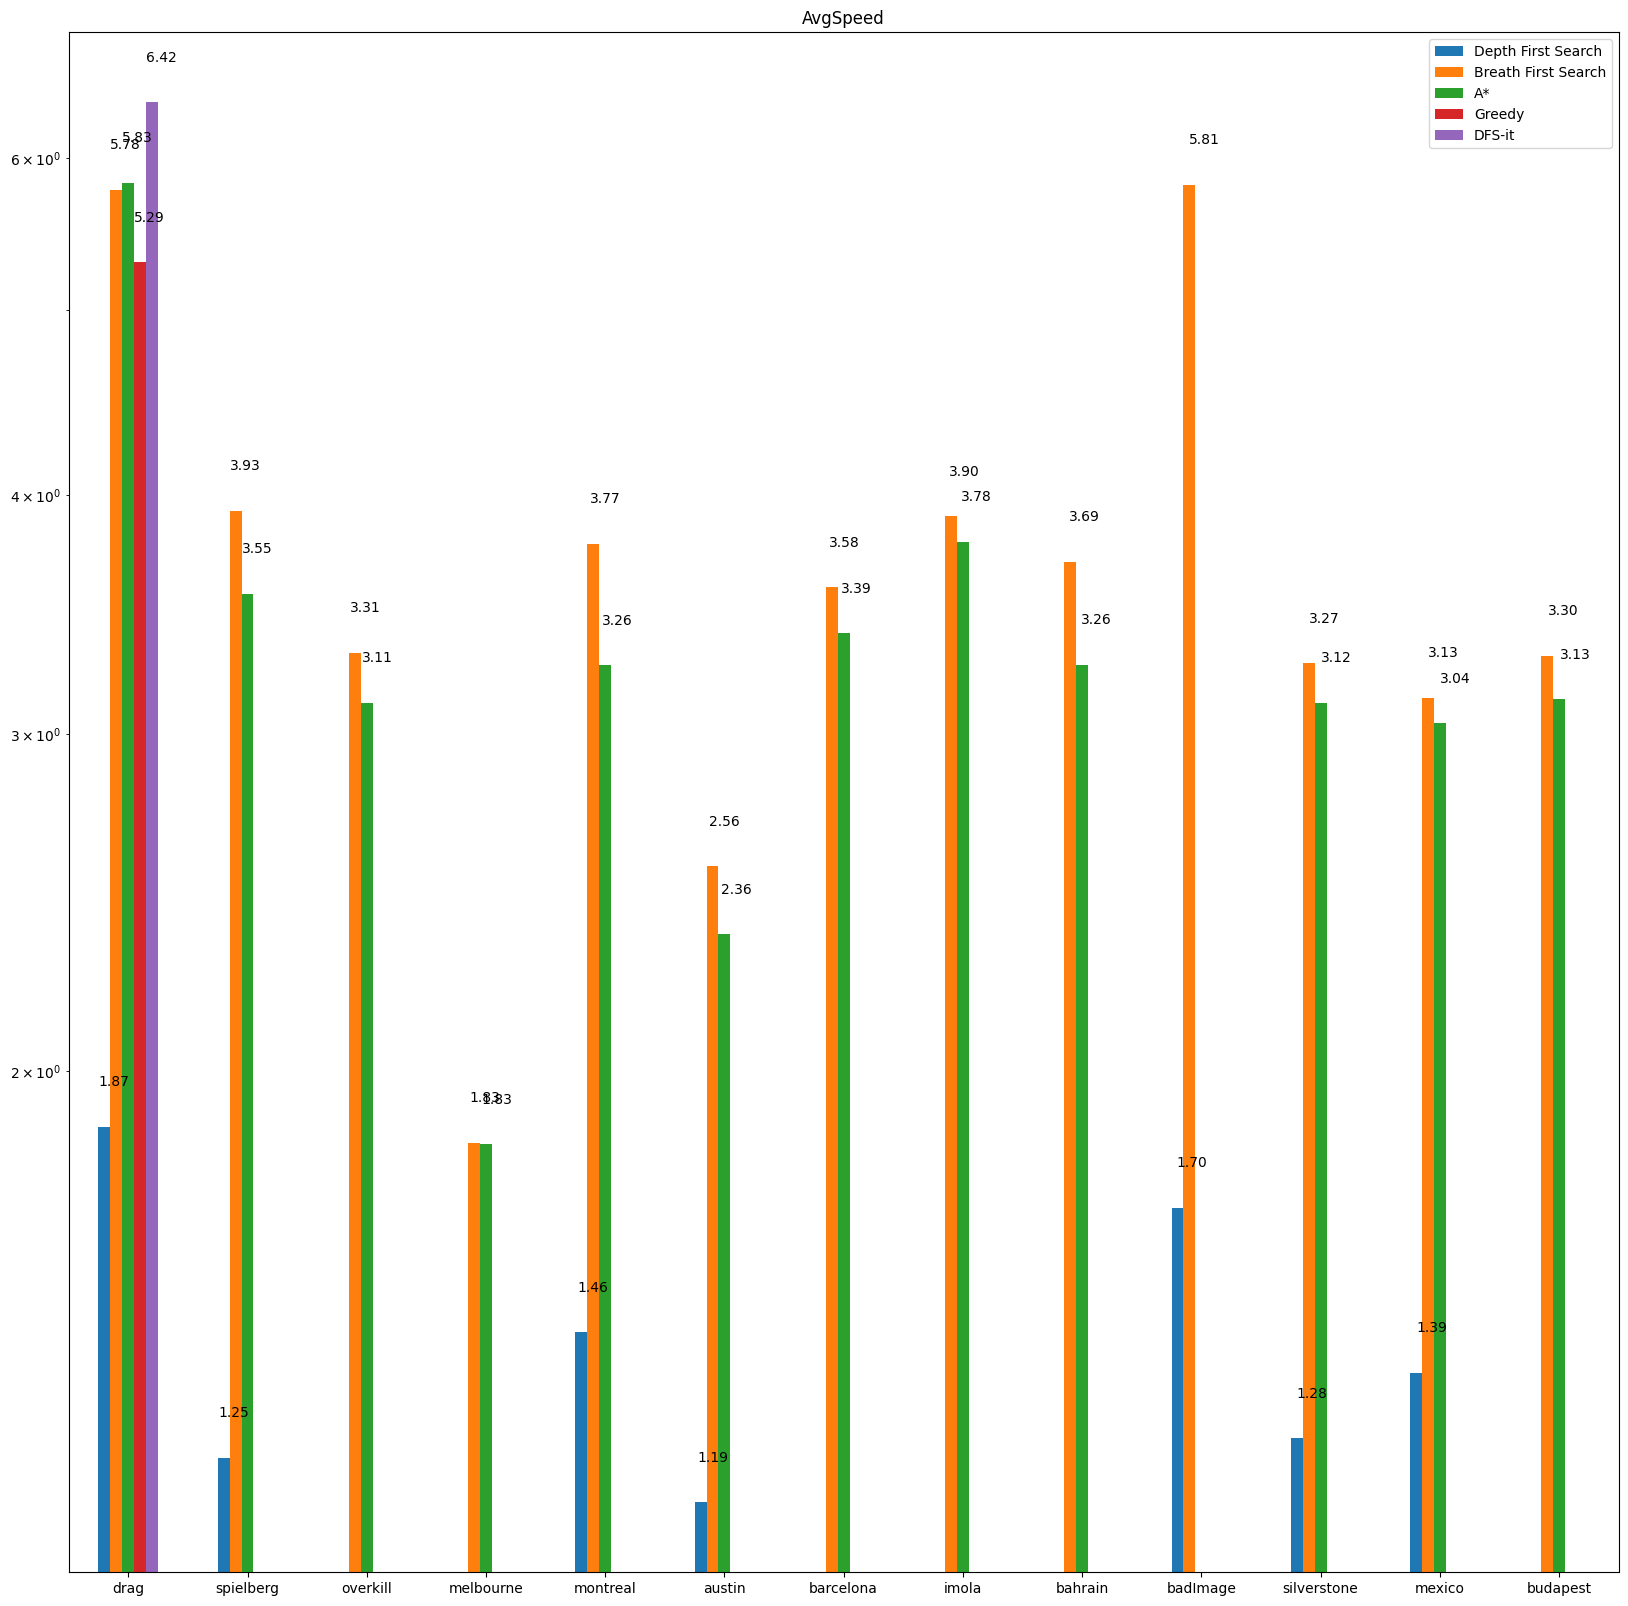

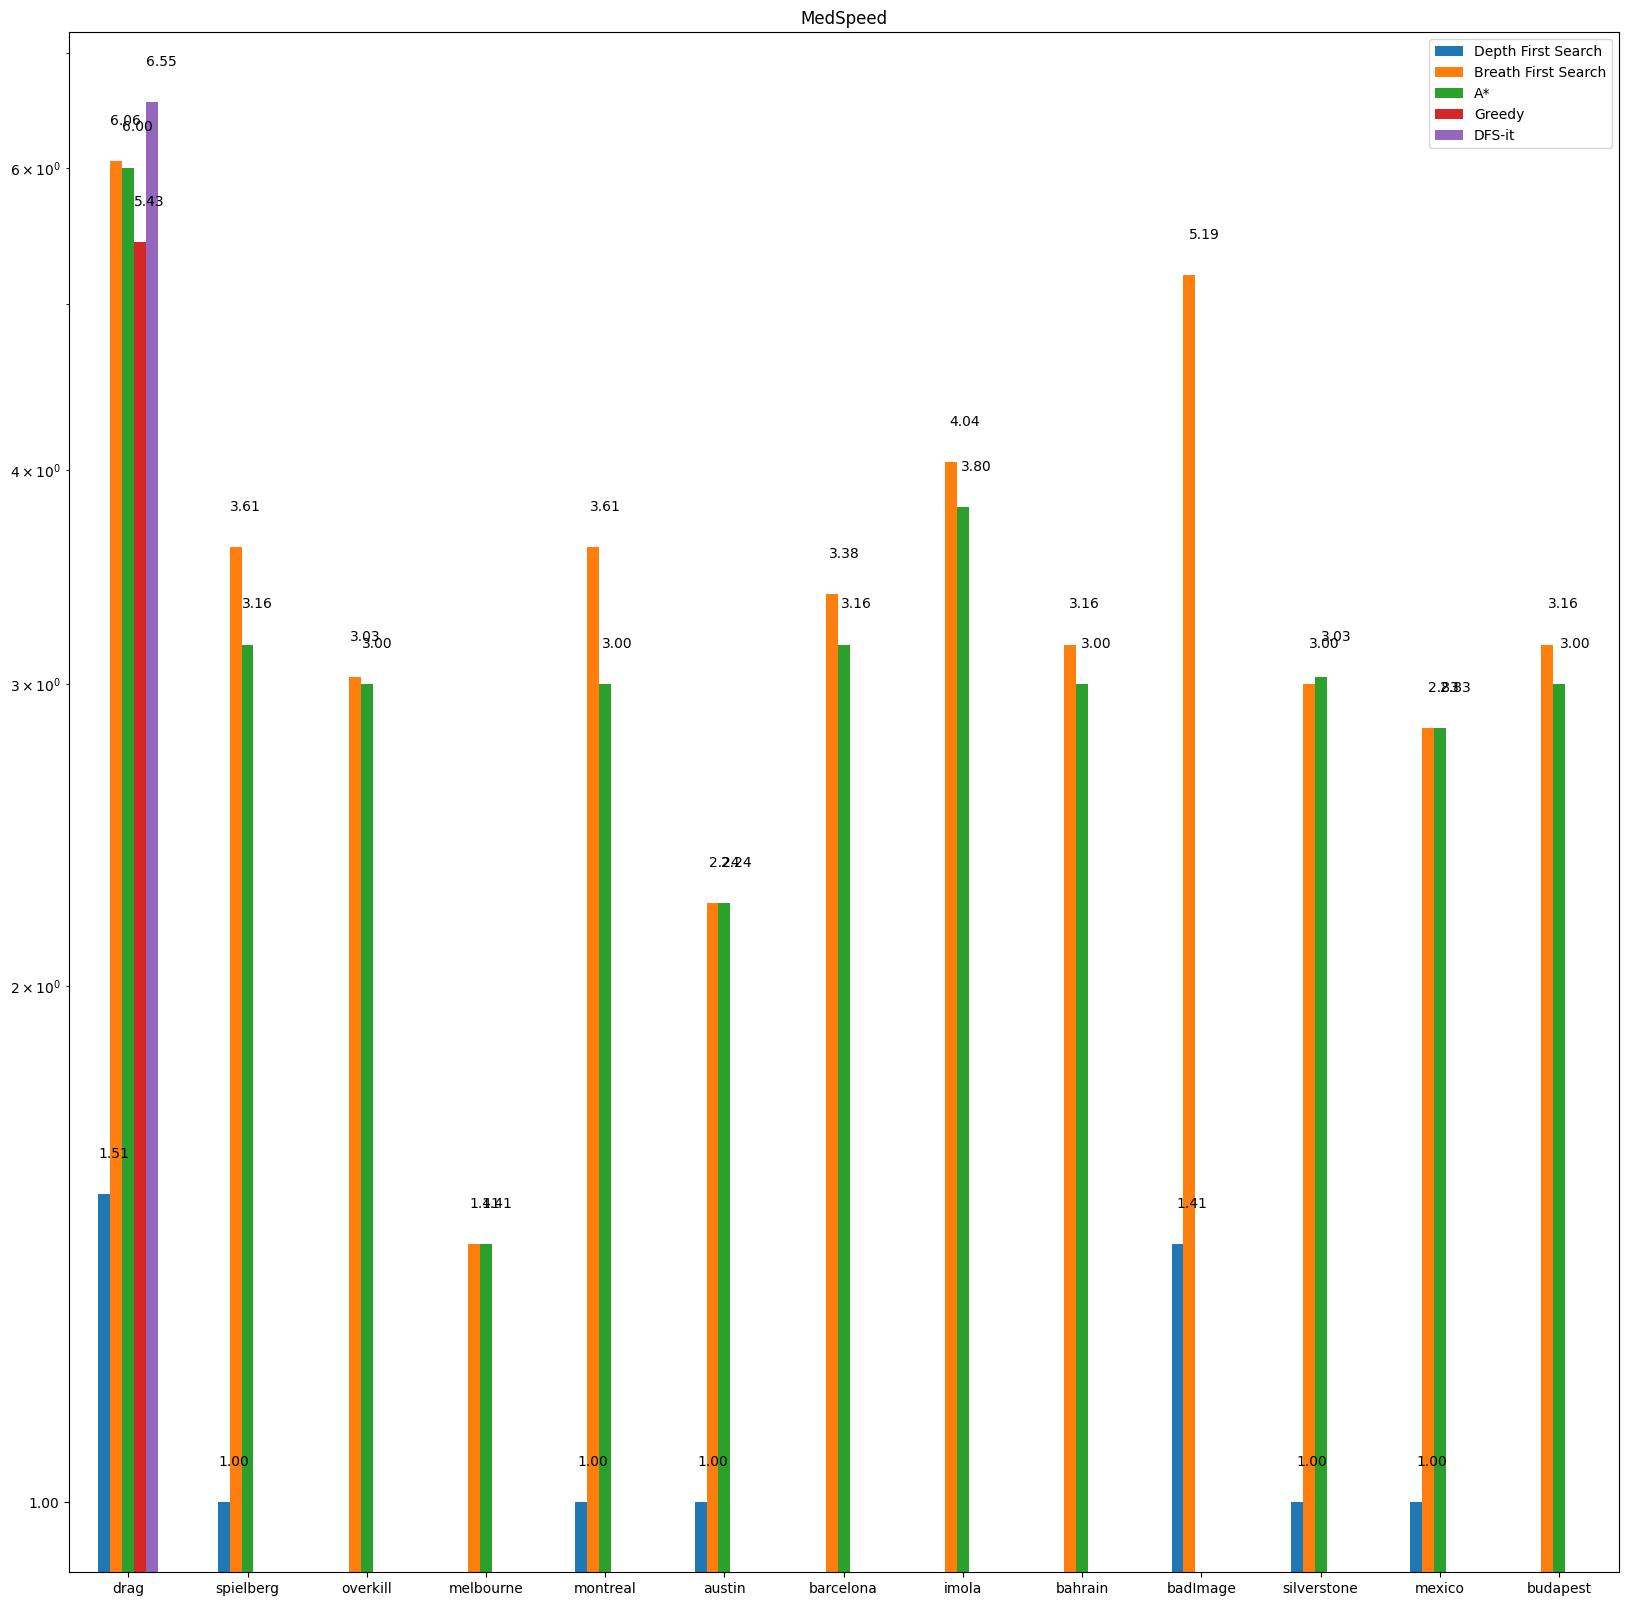

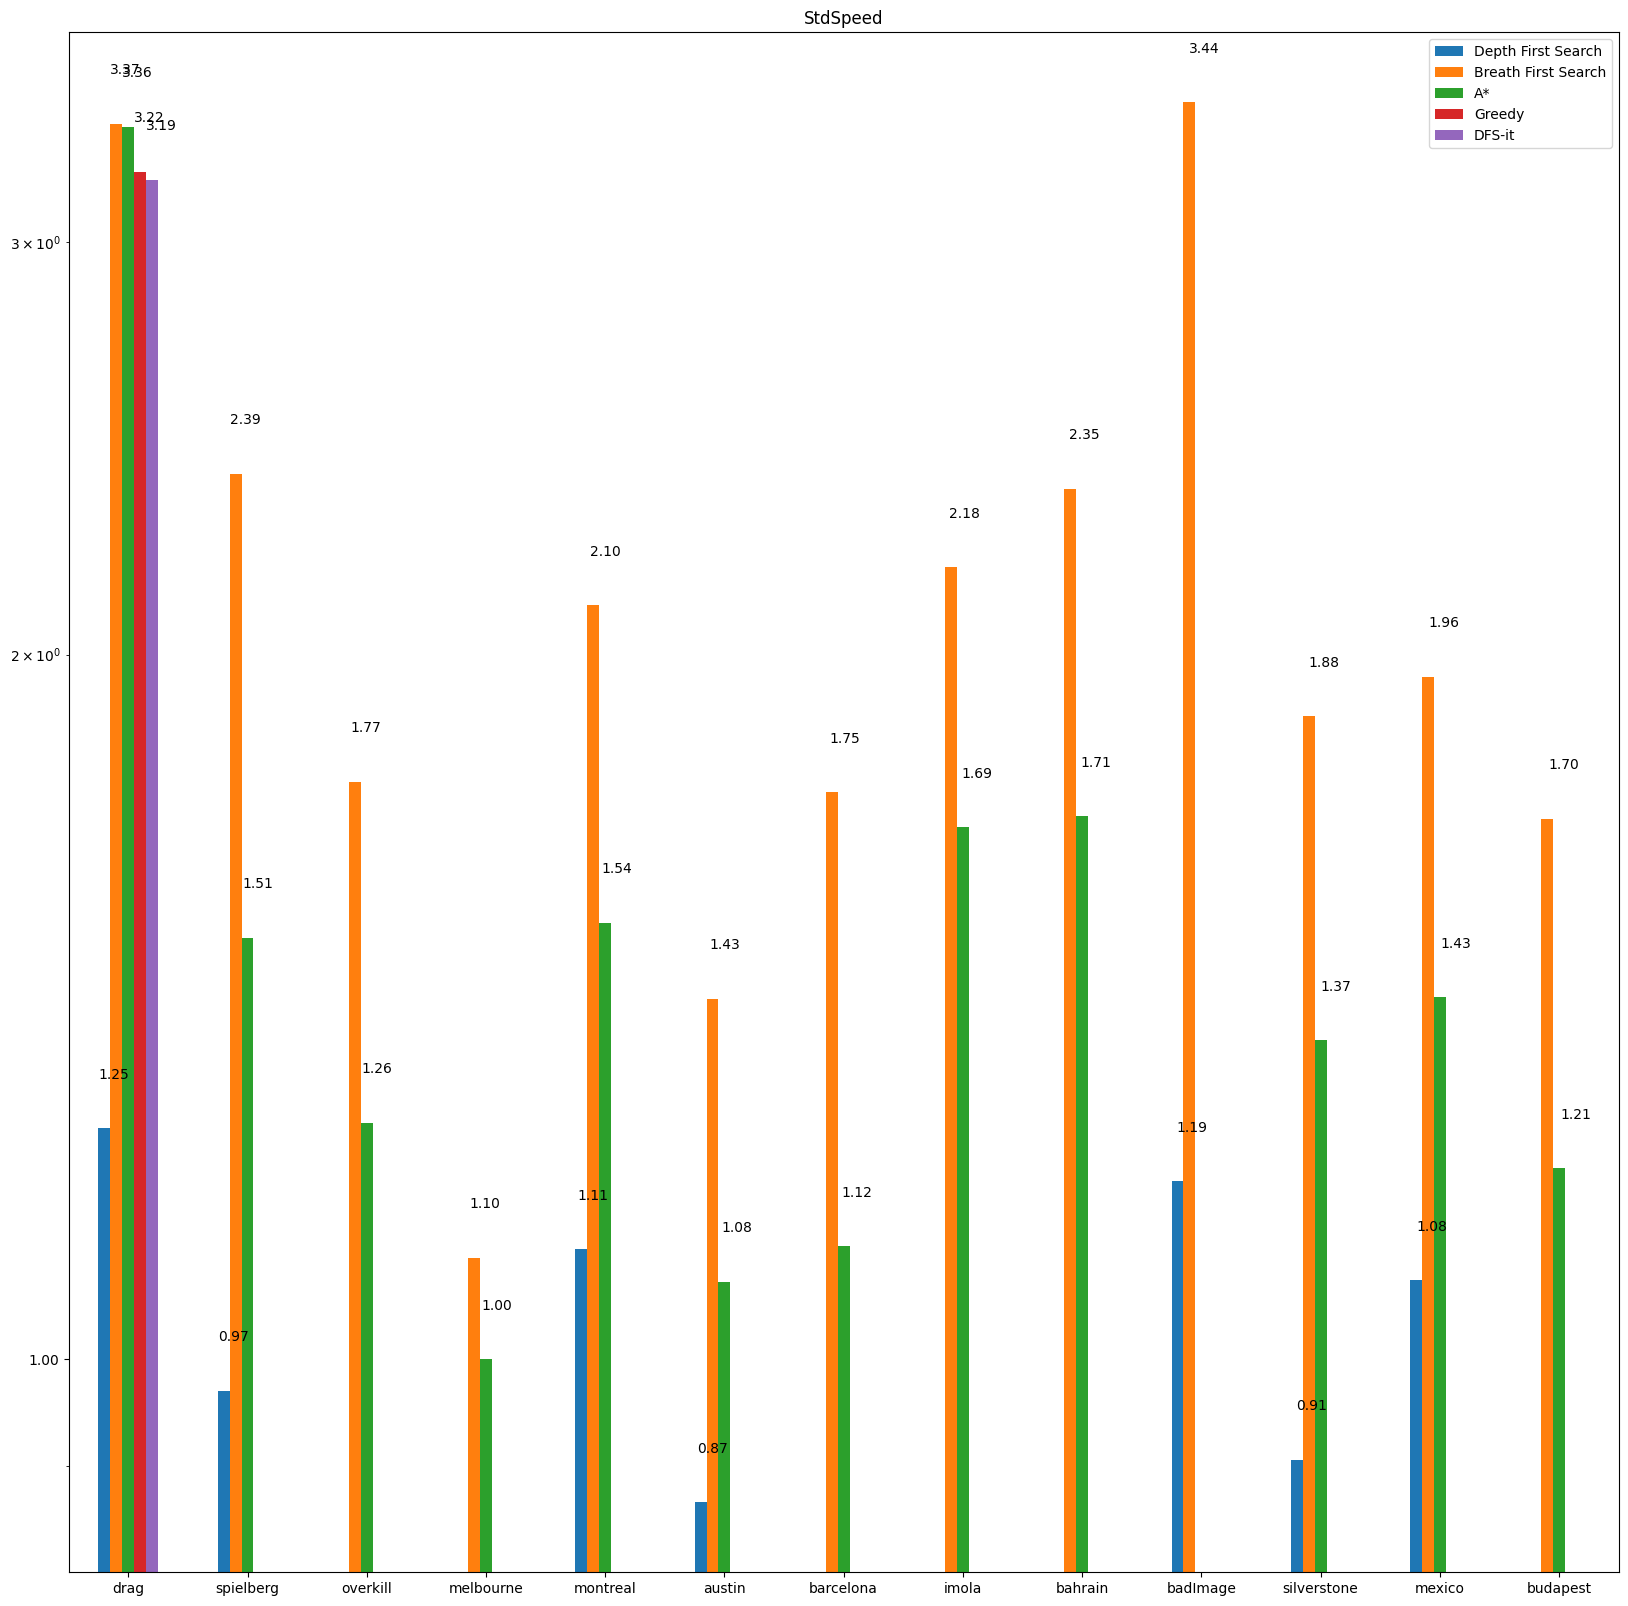

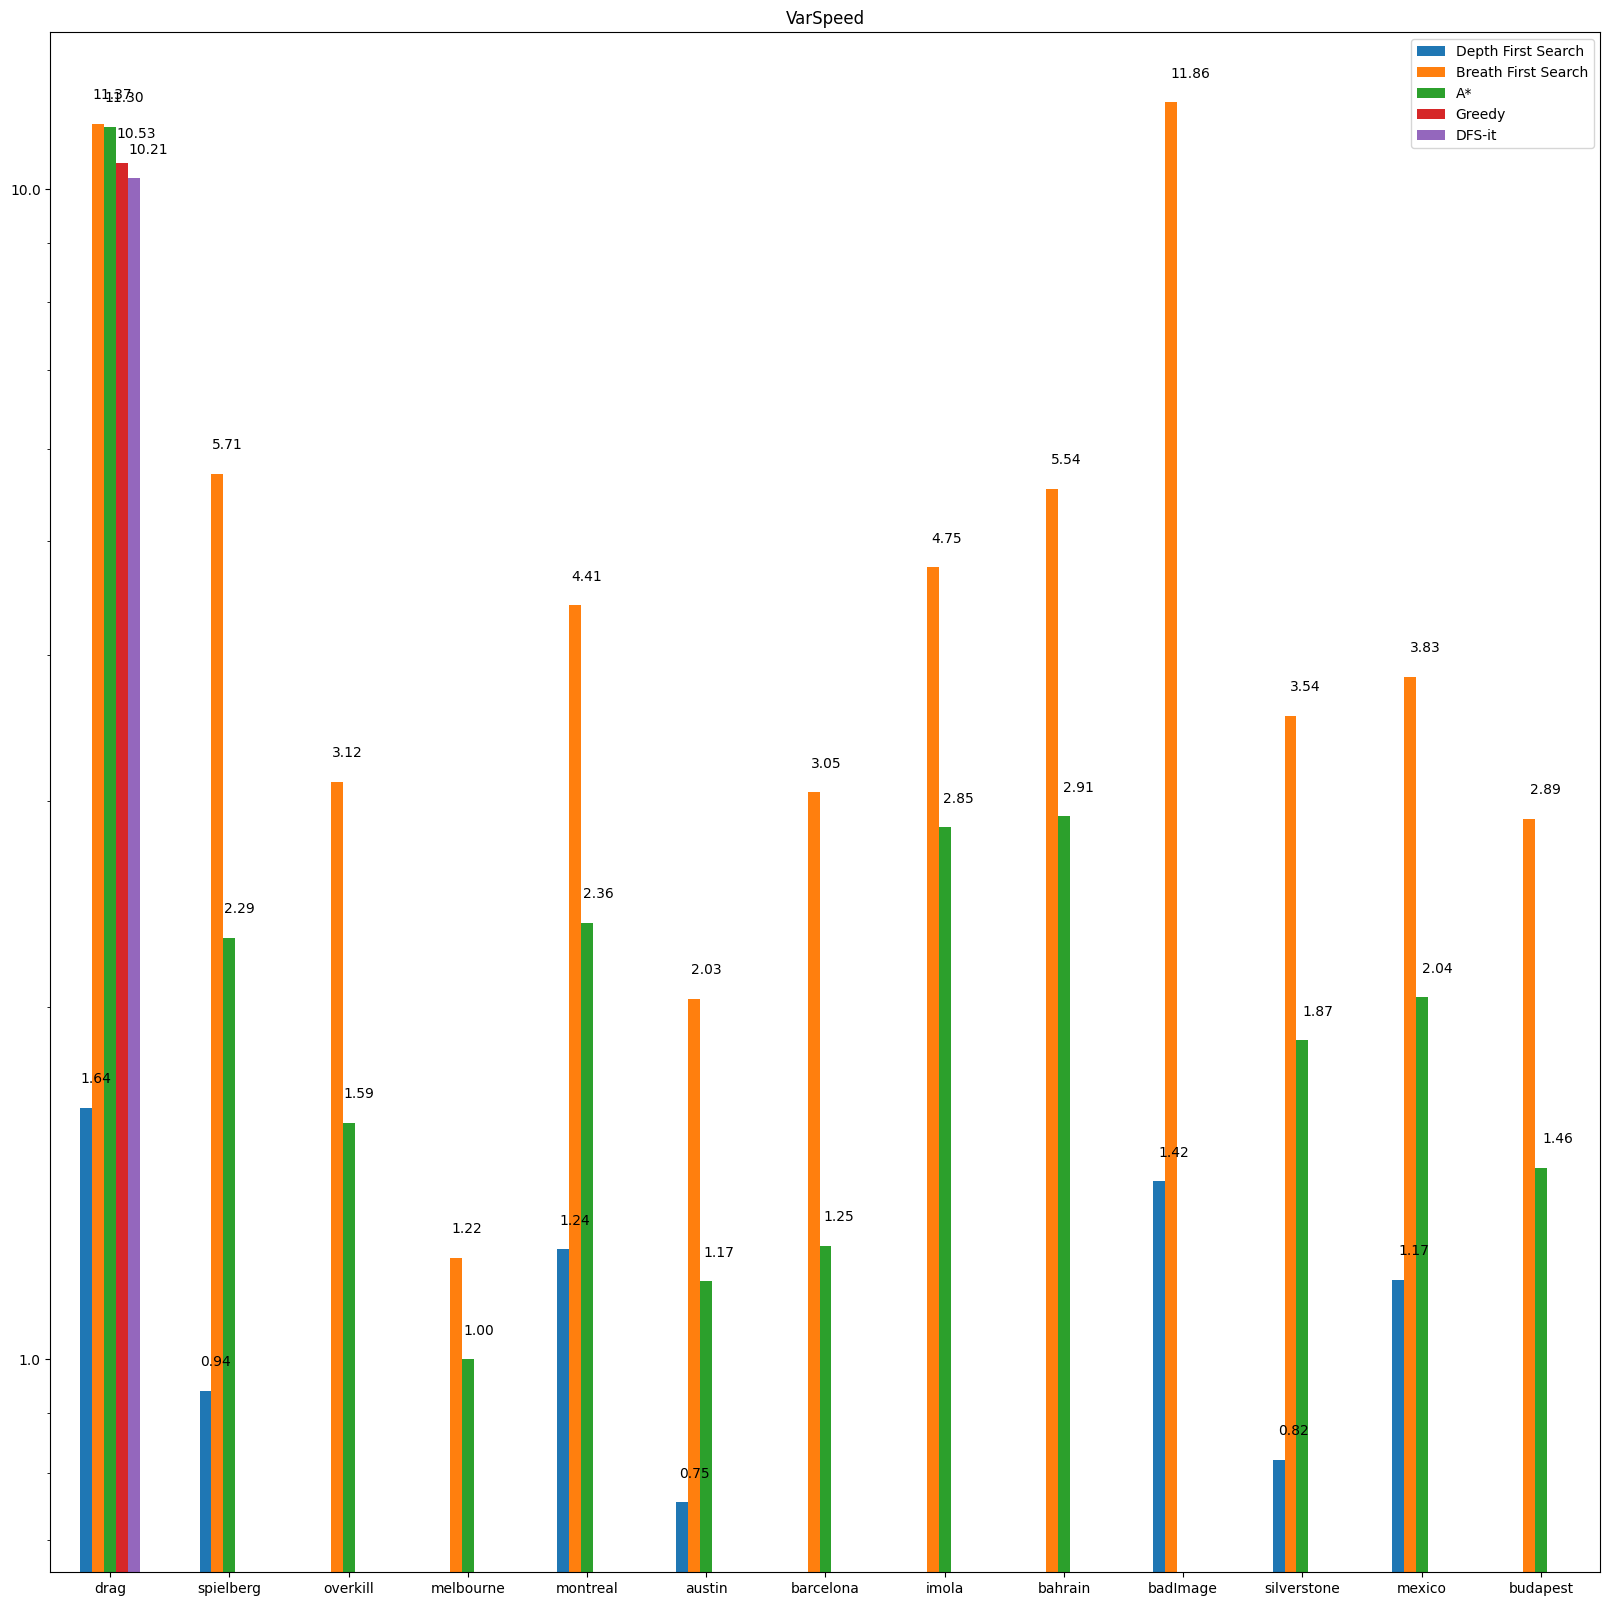

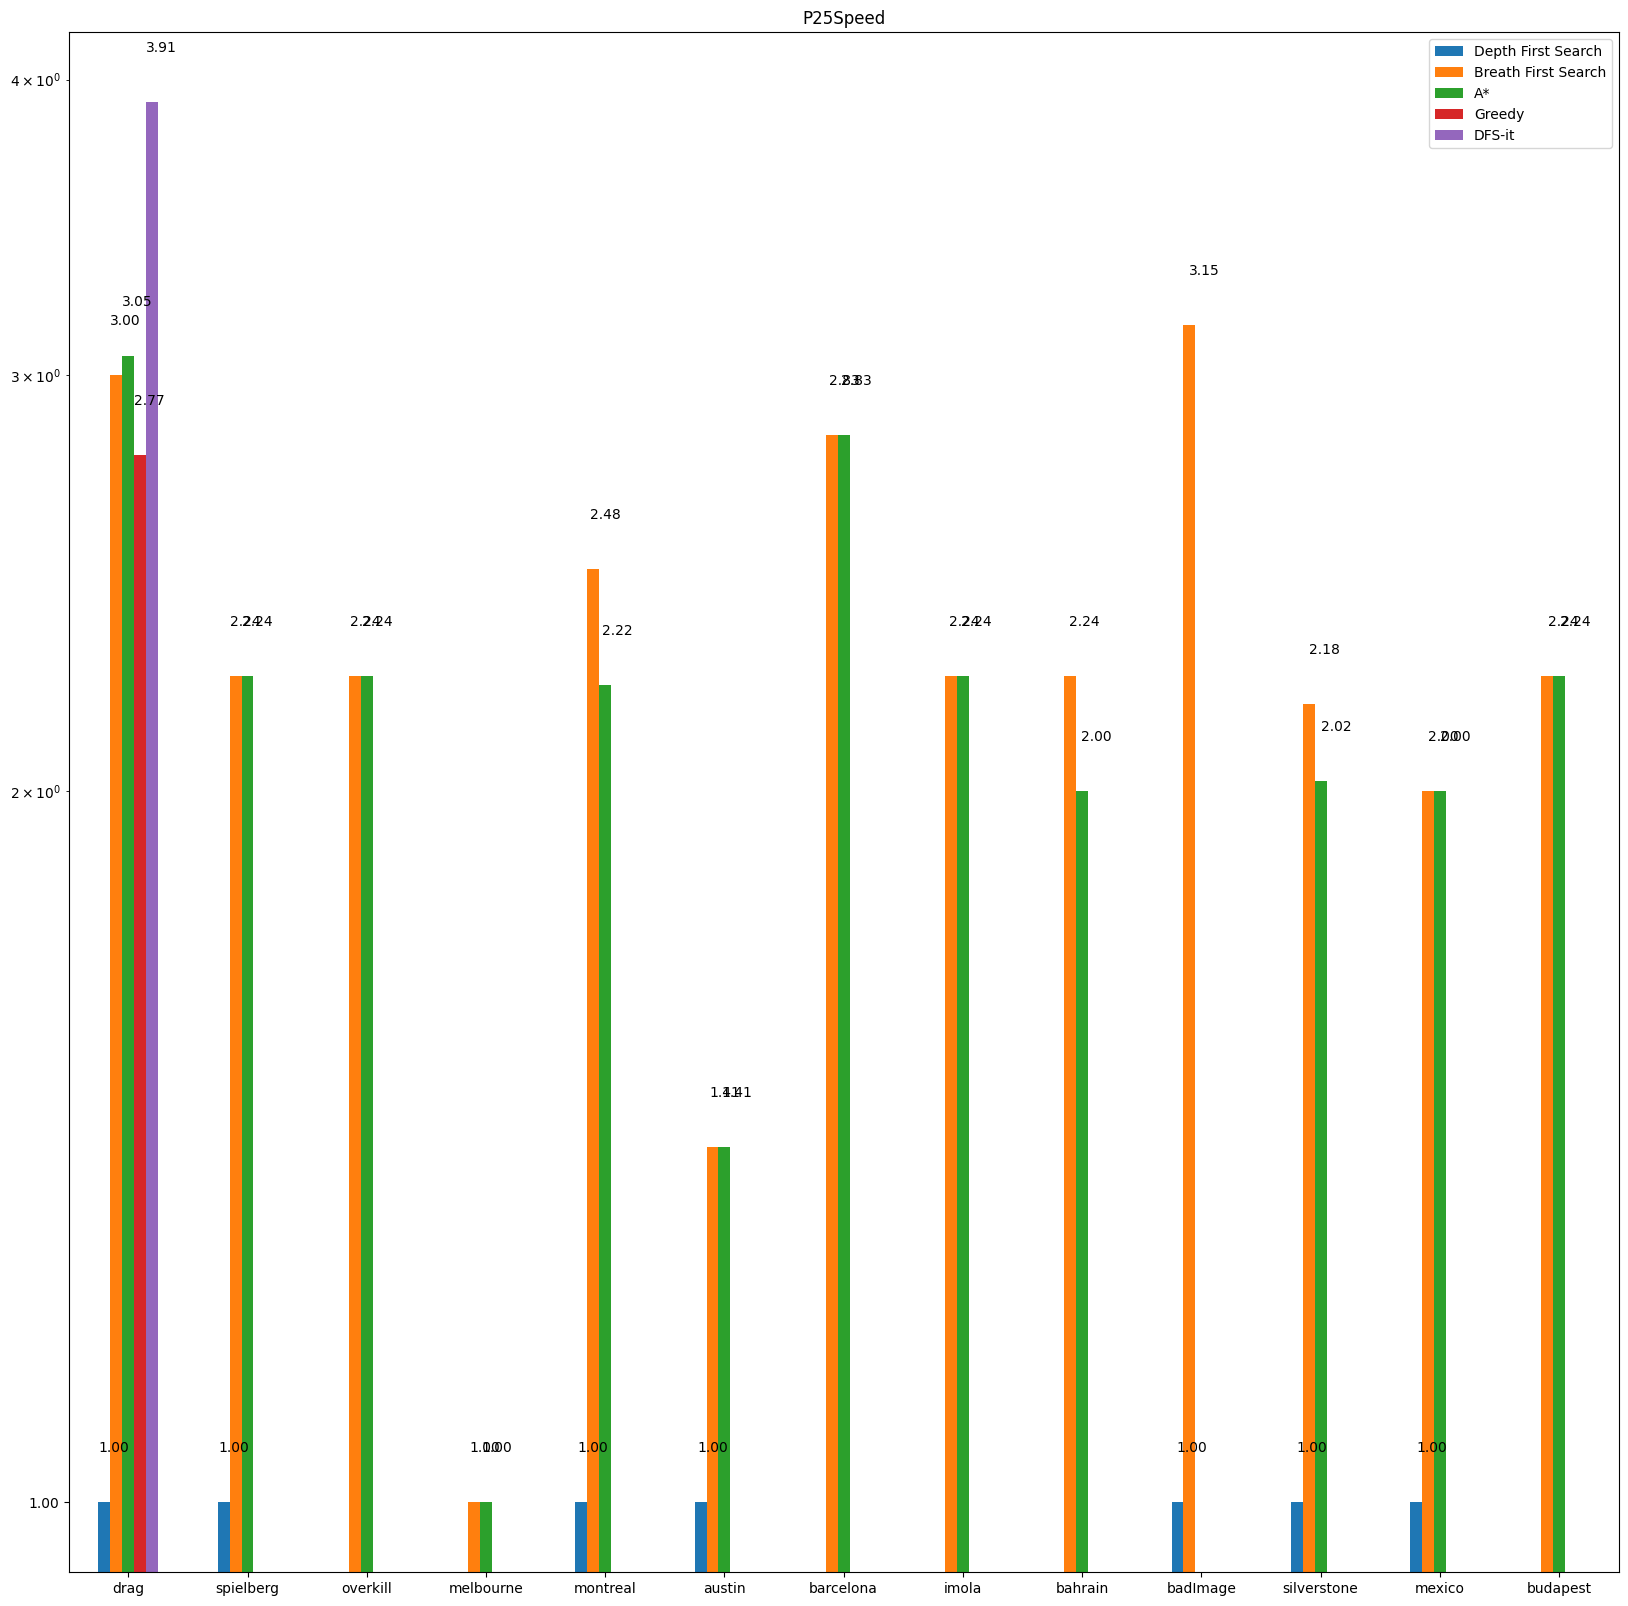

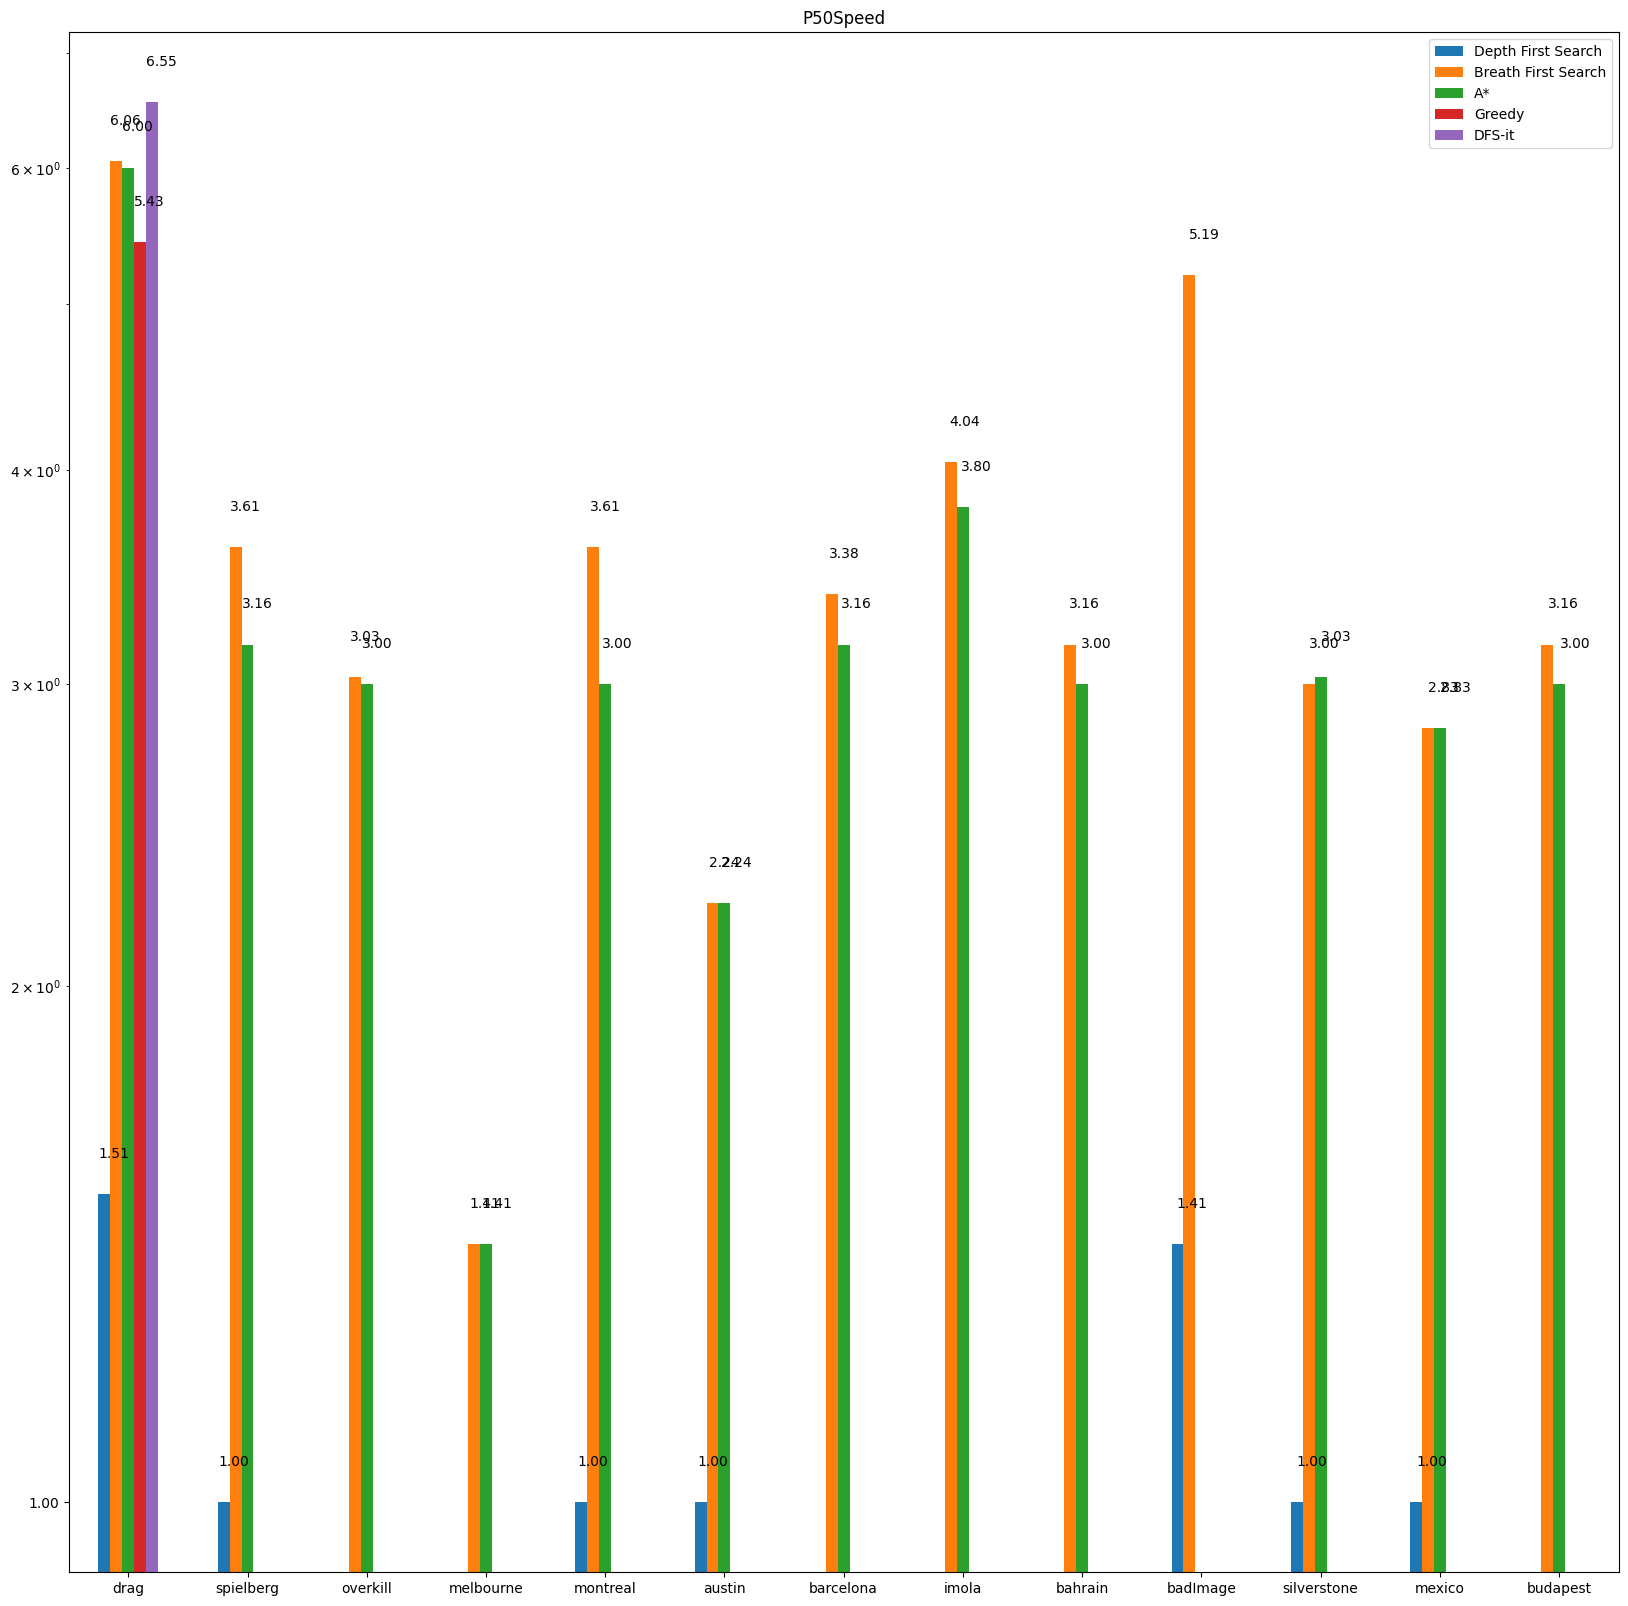

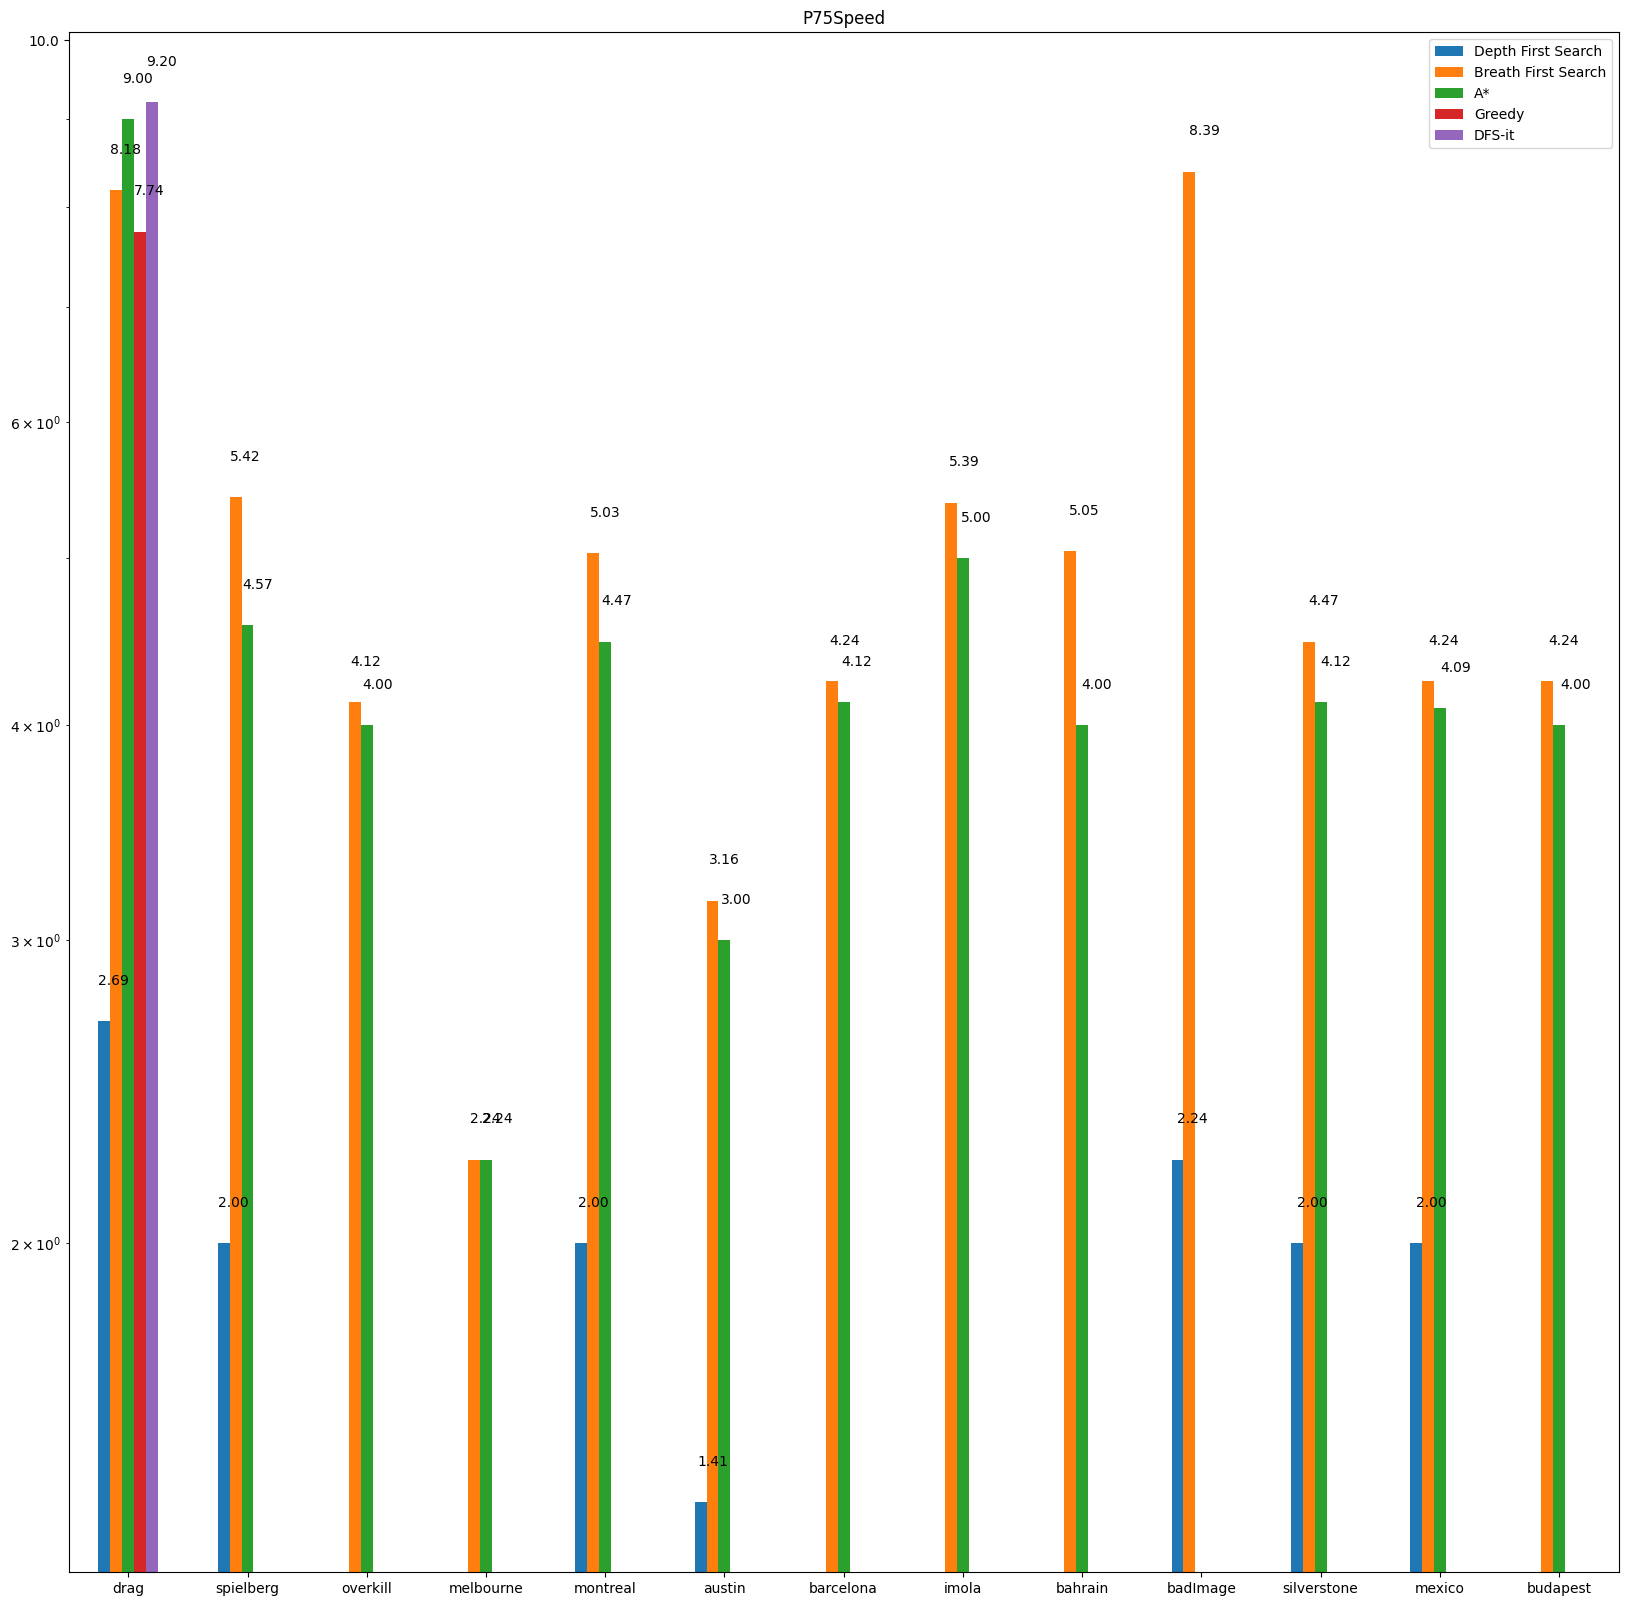

In [ ]:



dataframes={}
algorithmsNames=list(zip(*algorithms))[0]
for stat,statData in data.items():
    dataframes[stat]=pd.DataFrame.from_dict(statData,orient='index',columns=algorithmsNames)
for stat,df in dataframes.items():
    ax = df.plot(kind="bar", rot=0,title=stat,figsize=(20,20))
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.005, p.get_height() * 1.05))
